Saving metrics_base.csv to metrics_base (2).csv
Saving referential_base.csv to referential_base (2).csv

------ Resultados del clasificador con reglas ------
Accuracy: 0.9055
Recall (INCORRECT_ABSTRACTION): 0.3768

Matriz de confusión:


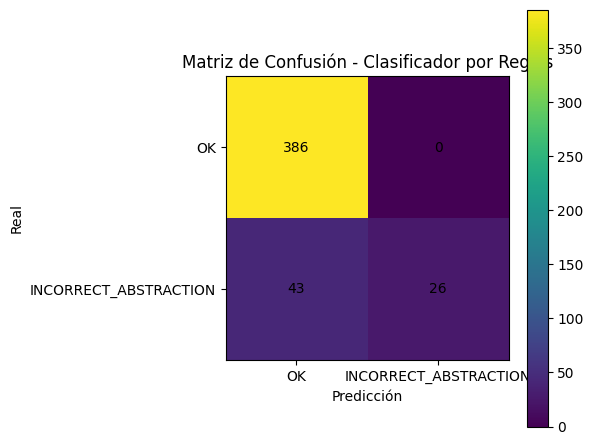


Falsos Negativos (real INCORRECT, predicción OK): 43
Falsos Positivos (real OK, predicción INCORRECT): 0


In [4]:
"""
Evaluación e implementación del clasificador basado en reglas.

Este valida componentes, variables y constantes comparando con la base de datos referencial.
Usa coincidencia exacta y fuzzy matching para detectar los errores de abstracción que cometa
el estudiante. Los ítems que no hacen match se clasifican como OK para evitar falsos positivos.

El desempeño se evalúa mediante accuracy, matriz de confusión y recall para la clase INCORRECT_ABSTRACTION.
"""

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Instalación de rapidfuzz para fuzzy matching
!pip -q install rapidfuzz

from rapidfuzz import process, fuzz
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

uploaded = files.upload()

# Se deben subir ambos archivos en un solo upload: referential_base.csv and metrics_base.csv

def find_uploaded(name_contains: str):
    for k in uploaded.keys():
        if name_contains.lower() in k.lower():
            return k
    return None

ref_file = find_uploaded("referential_base") or "referential_base.csv"
met_file = find_uploaded("metrics_base") or "metrics_base.csv"


# encode latin1 para el csv por el lenguaje (tildes en español)
ref_df = pd.read_csv(ref_file, encoding="latin1")
met_df = pd.read_csv(met_file, encoding="latin1")

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    rename_map = {
        "System ID": "SYSTEM_ID",
        "Response Category ID": "RESPONSE_CATEGORY_ID",
        "Item Normalized": "ITEM_NORMALIZED",
        "Error Subcategory ID": "ERROR_SUBCATEGORY_ID",
        "Feedback": "FEEDBACK",
        "Answer Text": "ANSWER_TEXT",
        "Error Category ID": "ERROR_CATEGORY_ID",
        "Item ID": "ITEM_ID",
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    return df
ref_df = pd.read_csv(ref_file, encoding="latin1")
met_df = pd.read_csv(met_file, encoding="latin1")

ref_df = standardize_columns(ref_df)
met_df = standardize_columns(met_df)


# Estas son validaciones para asegurar que el dataset que se suba contiene las columnas necesarias para la clasificación
ref_required = ["SYSTEM_ID", "RESPONSE_CATEGORY_ID", "ITEM_NORMALIZED", "ERROR_SUBCATEGORY_ID"]
met_required = ["SYSTEM_ID", "RESPONSE_CATEGORY_ID", "ITEM_NORMALIZED", "ERROR_SUBCATEGORY_ID"]

for c in ref_required:
    if c not in ref_df.columns:
        raise ValueError(f"En referential_base falta las columnas de: {c}. Encontradas: {list(ref_df.columns)}")

for c in met_required:
    if c not in met_df.columns:
        raise ValueError(f"En metrics_base faltan las columnas de: {c}. Encontradas: {list(met_df.columns)}")

# Al inicio hubo problemas por espacios en los nombres de las clases (ERROR_SUCATEGORY_ID), esto elimina los espacios de los labels
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["SYSTEM_ID"] = df["SYSTEM_ID"].astype(str).str.strip().str.upper()
    df["RESPONSE_CATEGORY_ID"] = df["RESPONSE_CATEGORY_ID"].astype(str).str.strip().str.upper()
    df["ITEM_NORMALIZED"] = df["ITEM_NORMALIZED"].astype(str).str.strip().str.lower()
    df["ERROR_SUBCATEGORY_ID"] = df["ERROR_SUBCATEGORY_ID"].astype(str).str.strip().str.upper()
    return df

ref_df = clean_cols(ref_df)
met_df = clean_cols(met_df)

VALID_CATS = {"COMPONENTS", "VARIABLES", "CONSTANTS"}
ref_df = ref_df[ref_df["RESPONSE_CATEGORY_ID"].isin(VALID_CATS)].copy()
met_df = met_df[met_df["RESPONSE_CATEGORY_ID"].isin(VALID_CATS)].copy()

ref_df_ok = ref_df[ref_df["ERROR_SUBCATEGORY_ID"] == "OK"].copy()

ok_sets = {}
for (sys_id, cat), group in ref_df_ok.groupby(["SYSTEM_ID", "RESPONSE_CATEGORY_ID"]):
    ok_sets.setdefault(sys_id, {})
    ok_sets[sys_id][cat] = set(group["ITEM_NORMALIZED"].tolist())

def get_candidates(sys_id: str):
    sys_sets = ok_sets.get(sys_id, {})
    all_items = set()
    for cat in VALID_CATS:
        all_items |= sys_sets.get(cat, set())
    return list(all_items)

# umbral para fuzzy matching
FUZZY_THRESHOLD = 85

def map_to_known_item(sys_id: str, student_item: str):
    """
    Busca coincidencia con el item del estudiante y el item de la base.
    Retorna el artículo mapeado, el tipo de coincidencia (fuzzy o exact) y el puntaje de similaridad (score).
    """
    student_item = (student_item or "").strip().lower()
    if not student_item:
        return None, None, None

    sys_sets = ok_sets.get(sys_id, {})
    all_ok = set().union(*[sys_sets.get(c, set()) for c in VALID_CATS]) if sys_sets else set()

    # Coincidencia exacta
    if student_item in all_ok:
        return student_item, "exact", 100

    # Fuzzy match
    candidates = get_candidates(sys_id)
    if not candidates:
        return None, None, None

    best = process.extractOne(
        student_item,
        candidates,
        scorer=fuzz.token_set_ratio
    )
    if best is None:
        return None, None, None

    mapped, score, _ = best
    if score >= FUZZY_THRESHOLD:
        return mapped, "fuzzy", score

    return None, None, score

def predict_binary(sys_id: str, category: str, student_item_norm: str):
    """
    Clasifica un ítem del estudiante en OK o INCORRECT_ABSTRACTION según las reglas.
    Retorna el label de la coincidencia y un diccionario con la información de la coincidencia.
    """
    sys_id = sys_id.upper().strip()
    category = category.upper().strip()

    mapped_item, match_type, score = map_to_known_item(sys_id, student_item_norm)

    # Si no hace match con nada, se clasifica como OK.
    if mapped_item is None:
        return "OK", {"match": None, "match_type": None, "score": score}

    comps = ok_sets.get(sys_id, {}).get("COMPONENTS", set())
    vars_  = ok_sets.get(sys_id, {}).get("VARIABLES", set())
    consts = ok_sets.get(sys_id, {}).get("CONSTANTS", set())

    if category == "COMPONENTS":
        if mapped_item in comps:
            return "OK", {"match": mapped_item, "match_type": match_type, "score": score}
        if mapped_item in vars_ or mapped_item in consts:
            return "INCORRECT_ABSTRACTION", {"match": mapped_item, "match_type": match_type, "score": score}
        return "OK", {"match": mapped_item, "match_type": match_type, "score": score}

    if category == "VARIABLES":
        if mapped_item in vars_:
            return "OK", {"match": mapped_item, "match_type": match_type, "score": score}
        if mapped_item in comps or mapped_item in consts:
            return "INCORRECT_ABSTRACTION", {"match": mapped_item, "match_type": match_type, "score": score}
        return "OK", {"match": mapped_item, "match_type": match_type, "score": score}

    if category == "CONSTANTS":
        if mapped_item in consts:
            return "OK", {"match": mapped_item, "match_type": match_type, "score": score}
        if mapped_item in vars_ or mapped_item in comps:
            return "INCORRECT_ABSTRACTION", {"match": mapped_item, "match_type": match_type, "score": score}
        return "OK", {"match": mapped_item, "match_type": match_type, "score": score}

    return "OK", {"match": mapped_item, "match_type": match_type, "score": score}


met_df["y_true"] = np.where(
    met_df["ERROR_SUBCATEGORY_ID"].str.upper() == "OK",
    "OK",
    "INCORRECT_ABSTRACTION"
)

preds = []
debug_match = []
for _, row in met_df.iterrows():
    pred, detail = predict_binary(
        row["SYSTEM_ID"],
        row["RESPONSE_CATEGORY_ID"],
        row["ITEM_NORMALIZED"]
    )
    preds.append(pred)
    debug_match.append(detail)

met_df["y_pred"] = preds
met_df["match_info"] = debug_match

# Métricas
labels_order = ["OK", "INCORRECT_ABSTRACTION"]
cm = confusion_matrix(met_df["y_true"], met_df["y_pred"], labels=labels_order)
acc = accuracy_score(met_df["y_true"], met_df["y_pred"])
recall_incorrect = recall_score(met_df["y_true"], met_df["y_pred"], pos_label="INCORRECT_ABSTRACTION")

print("\n------ Resultados del clasificador con reglas ------")
print(f"Accuracy: {acc:.4f}")
print(f"Recall (INCORRECT_ABSTRACTION): {recall_incorrect:.4f}")
print("\nMatriz de confusión:")

# Gráfico matriz de confusión
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusión - Clasificador por Reglas")
plt.xticks(range(len(labels_order)), labels_order, rotation=0)
plt.yticks(range(len(labels_order)), labels_order)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.tight_layout()
plt.show()


fn = met_df[(met_df["y_true"] == "INCORRECT_ABSTRACTION") & (met_df["y_pred"] == "OK")].copy()
fp = met_df[(met_df["y_true"] == "OK") & (met_df["y_pred"] == "INCORRECT_ABSTRACTION")].copy()

print("\nFalsos Negativos (real INCORRECT, predicción OK):", len(fn))
print("Falsos Positivos (real OK, predicción INCORRECT):", len(fp))
